# Late Airline Arrivals

In this project, I will use various machine learning techniques on a dataset of late airline arrivals to predict flight delay. A flight will only count as late if it is over 30 minutes late. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import boto3
import io

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.metrics import r2_score

from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

First, let's take a look at the data we have for the year 2008.

In [2]:
# Set up packages for loading in data
client = boto3.client('s3') #low-level functional API
resource = boto3.resource('s3') #high-level object-oriented API

# Load in training data labels
obj = client.get_object(Bucket='thinkful-projects', Key='2008.csv')
stream = io.BytesIO(obj['Body'].read())
y2008 = pd.read_csv(stream)
print(y2008.head())

   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4   2003.0        1955   2211.0   
1  2008      1           3          4    754.0         735   1002.0   
2  2008      1           3          4    628.0         620    804.0   
3  2008      1           3          4    926.0         930   1054.0   
4  2008      1           3          4   1829.0        1755   1959.0   

   CRSArrTime UniqueCarrier  FlightNum        ...         TaxiIn  TaxiOut  \
0        2225            WN        335        ...            4.0      8.0   
1        1000            WN       3231        ...            5.0     10.0   
2         750            WN        448        ...            3.0     17.0   
3        1100            WN       1746        ...            3.0      7.0   
4        1925            WN       3920        ...            3.0     10.0   

   Cancelled  CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0          0               NaN

In [3]:
#y2008 = pd.read_csv('2008.csv')
#print(y2008.shape)
#y2008.head()

We have 29 features and 7,009,728 datapoints. Let's see what kind of features we are working with.

In [4]:
print(y2008.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB
None


Many of these features appear to be directly related to the delay, such as WeatherDelay, NASDelay, Security Delay. Others appear to be arbitrarily assigned, such as FlightNum and UniqueCarrier. Features are a mixture of integers, floats, and objects. Categorical objects may be helpful to us in our analysis but may also be too sparsely distributed to be valuable.

Let's look into what kind of values are comprising these features and how those values are correlated with the outcome feature. For each feature that has less than 50 values, we will plot the average delay per value to see if certain values are associated with more delay. This will give us an idea of what features might be important enough to keep as dummy features.


Feature:  Year
1 values
[2008]


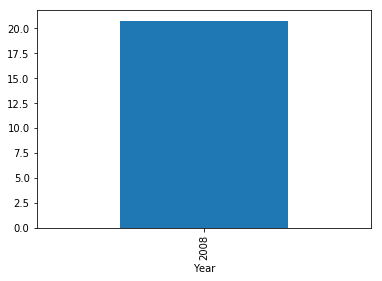


Feature:  Month
12 values
[ 1  2  3  4  5  6  7  8  9 10 11 12]


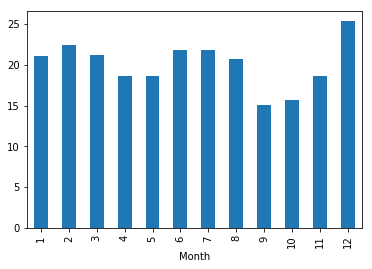


Feature:  DayofMonth
31 values
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31  2  1]


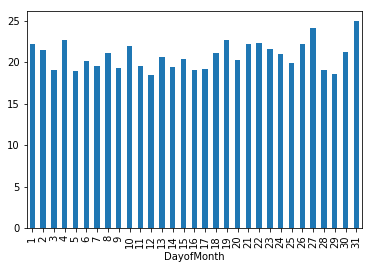


Feature:  DayOfWeek
7 values
[4 5 6 7 1 2 3]


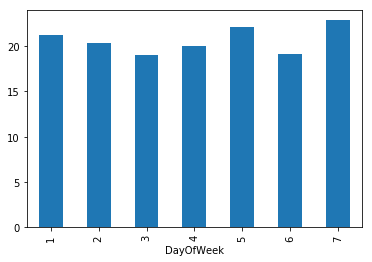


Feature:  DepTime
1441 values
[ 2003.   754.   628.   926.  1829.  1940.  1937.  1039.   617.  1620.]

Feature:  CRSDepTime
1217 values
[1955  735  620  930 1755 1915 1830 1040  615 1620]

Feature:  ArrTime
1441 values
[ 2211.  1002.   804.  1054.  1959.  2121.  2037.  1132.   652.  1639.]

Feature:  CRSArrTime
1378 values
[2225 1000  750 1100 1925 2110 1940 1150  650 1655]

Feature:  UniqueCarrier
20 values
['WN' 'XE' 'YV' 'OH' 'OO' 'UA' 'US' 'DL' 'EV' 'F9' 'FL' 'HA' 'MQ' 'NW' '9E'
 'AA' 'AQ' 'AS' 'B6' 'CO']


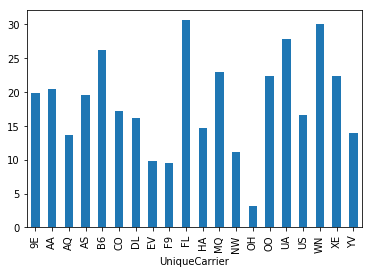


Feature:  FlightNum
7539 values
[ 335 3231  448 1746 3920  378  509  535   11  810]

Feature:  TailNum
5374 values
['N712SW' 'N772SW' 'N428WN' 'N612SW' 'N464WN' 'N726SW' 'N763SW' 'N689SW'
 'N648SW' 'N690SW']

Feature:  ActualElapsedTime
690 values
[ 128.   96.   88.   90.  101.  240.  233.   95.   79.  130.]

Feature:  CRSElapsedTime
526 values
[ 150.  145.   90.  115.  250.   95.  135.   55.   50.  240.]

Feature:  AirTime
664 values
[ 116.  113.   76.   78.   77.   87.  230.  219.   70.  106.]

Feature:  ArrDelay
1154 values
[-14.   2.  14.  -6.  34.  11.  57. -18. -16.   1.]

Feature:  DepDelay
1135 values
[  8.  19.  -4.  34.  25.  67.  -1.   2.   0.   6.]

Feature:  Origin
303 values
['IAD' 'IND' 'ISP' 'JAN' 'JAX' 'LAS' 'LAX' 'LBB' 'LIT' 'MAF']

Feature:  Dest
304 values
['TPA' 'BWI' 'JAX' 'LAS' 'MCI' 'MCO' 'MDW' 'PHX' 'FLL' 'PBI']

Feature:  Distance
1435 values
[ 810  515  688 1591  451  828  162 1489  838  220]

Feature:  TaxiIn
191 values
[  4.   5.   3.   7.   6.   9.   2.  

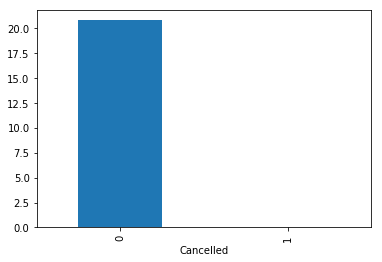


Feature:  CancellationCode
5 values
[nan 'A' 'C' 'B' 'D']


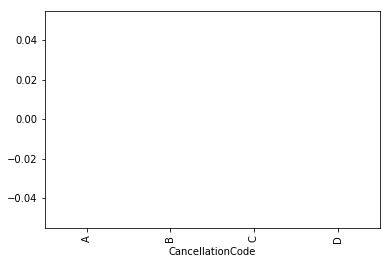


Feature:  Diverted
2 values
[0 1]


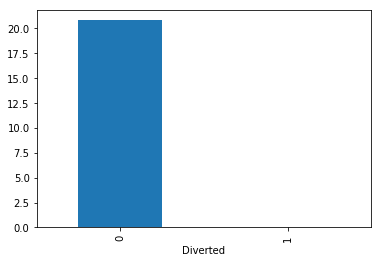


Feature:  CarrierDelay
985 values
[ nan   2.  10.   8.   3.   0.  12.   7.  40.   5.]

Feature:  WeatherDelay
600 values
[  nan    0.   24.   12.   22.    7.   25.  135.    3.    1.]

Feature:  NASDelay
575 values
[ nan   0.   6.  28.   4.  22.   8.   5.   7.  10.]

Feature:  SecurityDelay
157 values
[ nan   0.  10.   8.  12.   3.   9.   6.  11.  14.]

Feature:  LateAircraftDelay
565 values
[ nan  32.  47.  72.  12.  16.  25.   7.  59.  69.]


In [5]:
for column in y2008.columns:
    print('\nFeature: ', str(column))
    print(len(y2008[column].unique()), 'values')

    if len(y2008[column].unique()) < 50:
        print(y2008[column].unique())
        
        mean_per_value = y2008[[column,'LateAircraftDelay']].groupby(column).aggregate(np.mean)
        mean_per_value['LateAircraftDelay'].plot(kind = 'bar')
        plt.show()
    else:
        print(y2008[column].unique()[:10])

Since there is only one value for Year, this feature will be dropped. It appears that month may have an effect on aircraft delay. Day of the month is variable but there are no obvious trends; day of the week is somewhat constant.

Unique carrier seems to have a dramatic effect on the delay, with FL demonstrating the most and OH demonstrating the least. For the rest of the categorical features, there is too wide a range of values to create dummy features, as it would add too many features to the dataset. We will create dummy categories for Unique Carrier and drop the rest of the categorical features.

We will also drop the numerical feature 'FlightNum' as it is assigned arbitrarily and has no predictive power. 'Cancelled' and 'Diverted' will be dropped because they are outcomes, not contributing features; canceled and diverted flights are incapable of experiencing delay. However, they are also unable to be grouped under "on-time", so we will also remove all rows that are positive for either of these features. <br>

It may also be wise to remove all forms of delay: although they are numerical, they are too closely linked to the outcome of interest and will likely lead to overfitting. We will keep them for the time being as we continue exploring the data.

I will also drop the categorical feature UniqueCarrier because although certain carriers might be more prone to delays, adding 20 dummy features to our already large dataframe is too computationally expensive at this time. I will drop TailNum, Origin, and Dest for the same reason.

In [6]:
# Dropping all rows with canceled or diverted flights
y2008_red = y2008[y2008['Cancelled'] == 0]
y2008_red = y2008_red[y2008_red['Diverted'] == 0]
print(y2008_red.shape)
# Dropping some features and converting others to dummies
y2008_red = y2008_red.drop(['Year','FlightNum', 'TailNum', 'Origin','Dest', 'Cancelled', 'CancellationCode', 'Diverted'], axis = 1)
y2008_red = pd.get_dummies(y2008_red, columns = ['UniqueCarrier'])
print(y2008_red.head())
print(y2008_red.shape)

(6855029, 29)
   Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0      1           3          4   2003.0        1955   2211.0        2225   
1      1           3          4    754.0         735   1002.0        1000   
2      1           3          4    628.0         620    804.0         750   
3      1           3          4    926.0         930   1054.0        1100   
4      1           3          4   1829.0        1755   1959.0        1925   

   ActualElapsedTime  CRSElapsedTime  AirTime        ...         \
0              128.0           150.0    116.0        ...          
1              128.0           145.0    113.0        ...          
2               96.0            90.0     76.0        ...          
3               88.0            90.0     78.0        ...          
4               90.0            90.0     77.0        ...          

   UniqueCarrier_HA  UniqueCarrier_MQ  UniqueCarrier_NW  UniqueCarrier_OH  \
0                 0                 0      

That got rid of a few hundred thousand rows. We eliminated some columns, but added more dummy features so now we have 41 columns. Now, let's take a look at the range of delays for all the flights in our dataset.

In [7]:
print(y2008_red['LateAircraftDelay'].value_counts())

0.0       825317
15.0       19069
16.0       17678
17.0       16738
18.0       15856
19.0       14969
20.0       14925
21.0       13808
22.0       13327
14.0       13287
13.0       12818
23.0       12416
12.0       12396
24.0       12221
10.0       12009
11.0       11985
25.0       11932
9.0        11461
7.0        10922
8.0        10917
26.0       10878
6.0        10577
27.0       10518
28.0       10172
29.0        9737
30.0        9513
31.0        8995
5.0         8929
4.0         8544
32.0        8532
           ...  
443.0          1
442.0          1
438.0          1
1316.0         1
423.0          1
418.0          1
487.0          1
496.0          1
572.0          1
500.0          1
570.0          1
568.0          1
565.0          1
562.0          1
552.0          1
551.0          1
543.0          1
540.0          1
539.0          1
535.0          1
530.0          1
528.0          1
526.0          1
524.0          1
515.0          1
514.0          1
512.0          1
507.0         

Delays range between 15 minutes to 661 minutes (11 hrs). However, we must remember that flights are only considered late if they are over 30 minutes late. Let's take a look at the correlations we can observe between features.

In [8]:
corrmat = y2008_red.corr()
print(corrmat)

                      Month  DayofMonth  DayOfWeek   DepTime  CRSDepTime  \
Month              1.000000   -0.000402  -0.005350 -0.010321   -0.008426   
DayofMonth        -0.000402    1.000000   0.004762 -0.001555   -0.001745   
DayOfWeek         -0.005350    0.004762   1.000000  0.005660    0.005666   
DepTime           -0.010321   -0.001555   0.005660  1.000000    0.968550   
CRSDepTime        -0.008426   -0.001745   0.005666  0.968550    1.000000   
ArrTime           -0.000377   -0.001505   0.003376  0.713081    0.697293   
CRSArrTime         0.000353   -0.001744   0.005569  0.791431    0.790820   
ActualElapsedTime -0.014061    0.000598   0.012929 -0.017070   -0.017184   
CRSElapsedTime    -0.006345    0.001384   0.015013 -0.013684   -0.011774   
AirTime           -0.012413    0.000950   0.013915 -0.023170   -0.021086   
ArrDelay          -0.042058    0.001607   0.010558  0.178275    0.116894   
DepDelay          -0.030498    0.003299   0.015425  0.201981    0.138850   
Distance    

Although there are too many features to get a thorough read, I can tell that CRSDepTime, DepTime, ArrDelay, DepDelay, TaxiOut, CarrierDelay, and NASDelay all have strong correlation with the outcome (magnitude over 0.1). Naturally, arrival delay and departure delay will correlate strongly (above 0.5). In the same way that 'time in minutes' would correlate strongly with 'time in hours', the different categories of delay are correlated with the final delay but they don't add any predictive power. To build a good predictive model, we will remove all associated 'Delay' features because in the real world, we would not have the luxury of knowing these features well enough in advance to make a useful prediction.

In [9]:
y2008_red = y2008_red.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay','ArrDelay','DepDelay'], axis = 1)

Now, let's take a look at how much null data there is in our dataset so we can account for it when training our models.

In [10]:
# Calculate NaN values for each column
print(y2008_red.isnull().sum())

Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
Distance                   0
TaxiIn                     0
TaxiOut                    0
LateAircraftDelay    5330294
UniqueCarrier_9E           0
UniqueCarrier_AA           0
UniqueCarrier_AQ           0
UniqueCarrier_AS           0
UniqueCarrier_B6           0
UniqueCarrier_CO           0
UniqueCarrier_DL           0
UniqueCarrier_EV           0
UniqueCarrier_F9           0
UniqueCarrier_FL           0
UniqueCarrier_HA           0
UniqueCarrier_MQ           0
UniqueCarrier_NW           0
UniqueCarrier_OH           0
UniqueCarrier_OO           0
UniqueCarrier_UA           0
UniqueCarrier_US           0
UniqueCarrier_WN           0
UniqueCarrier_XE           0
UniqueCarrier_YV           0
dtype: int64


After dropping some columns, we see that the outcome is the only feature with NaN values. These value correspond to all the flights that experienced no delay. We will want to convert these to 0, as they will provide a valuable control group for the delayed flights. If we want to model delayed flights, it will be helpful to have a basis of non-delayed flights to compare them to. <br>

In [11]:
# Convert NaN values in outcome to 0
y2008_red[column] = y2008_red[column].replace(to_replace = 'NaN', value = 0)
print(y2008_red.isnull().sum())

Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
Distance                   0
TaxiIn                     0
TaxiOut                    0
LateAircraftDelay    5330294
UniqueCarrier_9E           0
UniqueCarrier_AA           0
UniqueCarrier_AQ           0
UniqueCarrier_AS           0
UniqueCarrier_B6           0
UniqueCarrier_CO           0
UniqueCarrier_DL           0
UniqueCarrier_EV           0
UniqueCarrier_F9           0
UniqueCarrier_FL           0
UniqueCarrier_HA           0
UniqueCarrier_MQ           0
UniqueCarrier_NW           0
UniqueCarrier_OH           0
UniqueCarrier_OO           0
UniqueCarrier_UA           0
UniqueCarrier_US           0
UniqueCarrier_WN           0
UniqueCarrier_XE           0
UniqueCarrier_YV           0
dtype: int64


Now let's separate the late flights from the on-time flights so we can evenly sample them and prevent class imbalance. Although we are trying to predict how late flights will be, we will need just as many on-time flights to serve as a comparison for when the predicted flight delay is 0-30 min (considered on-time).

In [12]:
late = y2008_red.ix[y2008['LateAircraftDelay'] > 30]
print('Number of Delayed Flights:', len(late))

on_time = y2008_red.ix[y2008['LateAircraftDelay'] <= 30]
print('Number of On-time Flights:', len(on_time))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Number of Delayed Flights: 337060
Number of On-time Flights: 1187675


Because there are many more on-time flights than delayed flights, we will need to choose a random sample of on-time flights to match the size of the delayed sample. We will the combine them back into one dataset for input into our machine learning models. <br>

I will also reserve 20% of the data for external validation.

In [13]:
on_time_red = on_time.sample(len(late))
combined = late.append(on_time_red, ignore_index=True)
X = combined.drop('LateAircraftDelay',axis=1)
Y = combined['LateAircraftDelay']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

First, I will try  linear regression, as it is very computationally cheap and convenient to run. I will use 5 fold cross-validation on the training dataset to prevent overfitting. Since I am using regression, I will judge different models based on their resultant R2 score.

In [16]:
def run_linear_cv(X, Y):
    lr = linear_model.LinearRegression()
    lr.fit(X, Y)

    scores = cross_validation.cross_val_score(lr, X, Y, cv=5)
    Y_pred = lr.predict(X)

    print(f'Cross Validation Score: {scores.mean()}')
    print(f'R2 Score: {r2_score(Y_pred, Y)}\n')
    
run_linear_cv(X_train, Y_train)

Cross Validation Score: 0.11709237189146418
R2 Score: -6.526948232998854



Using linear regression on the cross-validated dataset, we can see that linear regression is not a valid way to fit our data. The training r2 value is negative, which means that our model fits the data worse than a horizontal line would. A second machine learning regressor performing poorly indicates that there is something wrong with our dataset and we should take measures to fix the dataset before applying any more machine learning models. <br>

Now that we have added quite a few dummy features, our dataset has become very sparse. Let's try using PCA to condense our feature set into fewer, more impactful features.

Percentage of total variance in dataset explained by each component:
 [  1.28869162e-01   8.14867333e-02   4.19971069e-02   3.55703972e-02
   3.53617474e-02   3.31320283e-02   3.30438017e-02   3.25901557e-02
   3.21971396e-02   3.20828793e-02   3.19619373e-02   3.19422432e-02
   3.17741520e-02   3.15699707e-02   3.13848672e-02   3.12016402e-02
   3.10462997e-02   3.07405138e-02   3.06998348e-02   3.04245625e-02
   3.02126930e-02   2.93078877e-02   2.76282697e-02   2.68941807e-02
   2.51754550e-02   2.36599895e-02   2.22082807e-02   9.13419696e-03
   5.36593447e-03   9.19968020e-04   4.15971514e-04   2.54149609e-32
   1.91406027e-33]
Covariance Matrix:
 [[ 1.00000185  0.06642872  0.0152555  ...,  0.00632787 -0.02794042
   0.00223568]
 [ 0.06642872  1.00000185  0.03190832 ...,  0.00205168 -0.001216   -0.0011011 ]
 [ 0.0152555   0.03190832  1.00000185 ...,  0.01575497 -0.02234335
   0.00391168]
 ..., 
 [ 0.00632787  0.00205168  0.01575497 ...,  1.00000185 -0.11274887
  -0.08309792]
 [-0.0

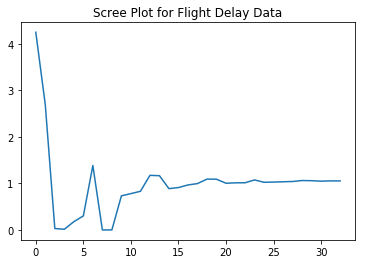

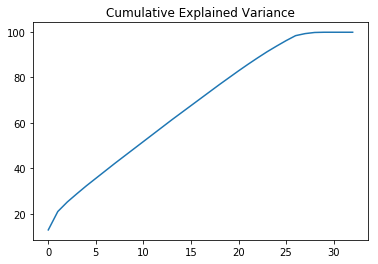

In [17]:
X_scaled = StandardScaler().fit_transform(X_train)
sklearn_pca = PCA()
sklearn_pca.fit(X_scaled)

print(
    'Percentage of total variance in dataset explained by each component:\n',
    sklearn_pca.explained_variance_ratio_
)

Xt = X_scaled.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title("Scree Plot for Flight Delay Data")
plt.show()

# Calculate cumulative sum of variance explained with [n] features
var=np.cumsum(np.round(sklearn_pca.explained_variance_ratio_, decimals=3)*100)
plt.plot(var)
plt.title("Cumulative Explained Variance")
plt.show()

A general rule of thumb is to keep only enough features to retain 85% of the variance. Judging by the plot above, we should keep 20 features. We will not transform our dataset to include 20 components.

In [20]:
sklearn_pca = PCA(n_components = 20)
sklearn_pca.fit(X_scaled)
X_train_pca = sklearn_pca.transform(X_scaled)
X_train_pca_df = pd.DataFrame(data=X_train_pca)

X_scaled_test = StandardScaler().fit_transform(X_test)
sklearn_pca_test = PCA(n_components = 20)
sklearn_pca_test.fit(X_scaled_test)
X_test_pca = sklearn_pca.transform(X_scaled_test)
X_test_pca_df = pd.DataFrame(data=X_test_pca)

Now, let's try re-running our logistic regressor with our PCA-transformed dataset.

In [21]:
run_linear_cv(X_train_pca_df, Y_train)

Cross Validation Score: 0.0762784634728247
R2 Score: -11.095778349754493



In [22]:
def run_linear_val(X_train, Y_train, X_test, Y_test):
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)

    print(f'R2 Score: {r2_score(Y_pred, Y_test)}\n') 
    
run_linear_val(X_train_pca_df, Y_train, X_test_pca_df, Y_test)

R2 Score: -10.932743458475185



Linear regression is a poor fit for both our original and transformed datasets. The negative R2 score for training and validation supports this assertion. One possible reason for this is that linear regression assumes no multicollinearity between features, which is not the case here. Several of the features are closely linked to each other, like arrival and departure time. We will use a more complicated algorithm that is better equipped to handle multicollinear features: decision tree/random forest.

In [25]:
def run_tree_cv (X, Y, depth_max, feature_max, min_split):

    dtree = DecisionTreeRegressor(
        max_depth = depth_max,
        random_state = 1,
        max_features = feature_max,
        min_samples_split = min_split
    )
    dtree.fit(X, Y)
    
    scores = cross_validation.cross_val_score(dtree, X, Y, cv=3)
    Y_pred = dtree.predict(X)
    
    print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Min Samples Split = {min_split}')
    print(f'Cross Validation Score: {scores.mean()}')
    print(f'R2 Score: {r2_score(Y_pred, Y)}\n')
    
    current_run = {'max depth': depth_max, 
                    'max features': feature_max,
                    'min samples split': min_split,
                    'cross-val score': scores.mean(),
                    'r2 score': r2_score(Y_pred, Y)}
    runs.append(current_run)

runs = []
depth_maxs = [5, 10, 20]
feature_maxs = [5, 10, 20]
min_splits = [5, 10, 20]

for depth_max in depth_maxs:
        for feature_max in feature_maxs:
            for min_split in min_splits:
                run_tree_cv(X_train_pca_df, Y_train, depth_max, feature_max, min_split)
                    
runs.sort(key = lambda run: run['cross-val score'])
print(runs[-1])

Max Depth: 5, Max Feature = 5, Min Samples Split = 5
Cross Validation Score: 0.0572678035269093
R2 Score: -13.99741691538256

Max Depth: 5, Max Feature = 5, Min Samples Split = 10
Cross Validation Score: 0.0572678035269093
R2 Score: -14.00030740140983

Max Depth: 5, Max Feature = 5, Min Samples Split = 20
Cross Validation Score: 0.0572678035269093
R2 Score: -14.00030740140983

Max Depth: 5, Max Feature = 10, Min Samples Split = 5
Cross Validation Score: 0.08359789038171961
R2 Score: -9.38220164245564

Max Depth: 5, Max Feature = 10, Min Samples Split = 10
Cross Validation Score: 0.08359789038171961
R2 Score: -9.38220164245564

Max Depth: 5, Max Feature = 10, Min Samples Split = 20
Cross Validation Score: 0.08359789038171961
R2 Score: -9.38220164245564

Max Depth: 5, Max Feature = 20, Min Samples Split = 5
Cross Validation Score: 0.07940508217185598
R2 Score: -10.239538780189184

Max Depth: 5, Max Feature = 20, Min Samples Split = 10
Cross Validation Score: 0.07940508217185598
R2 Score:

In [26]:
tree_maxdp = runs[-1]['max depth']
tree_maxft = runs[-1]['max features']
tree_minss = runs[-1]['min samples split']

def run_tree_val(X_train, Y_train, X_test, Y_test, depth_max, feature_max, min_split):
    dtree = DecisionTreeRegressor(
        max_depth = depth_max,
        random_state = 1,
        max_features = feature_max,
        min_samples_split = min_split
    )
    dtree.fit(X_train, Y_train)
    
    Y_pred = dtree.predict(X_test)
    
    print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Min Samples Split = {min_split}')
    print(f'R2 Score: {r2_score(Y_pred, Y_test)}\n')
    
run_tree_val(X_train_pca_df, Y_train, X_test_pca_df, Y_test, tree_maxdp, tree_maxft, tree_minss)

Max Depth: 10, Max Feature = 20, Min Samples Split = 20
R2 Score: -4.428582899947553



After running 2 different machine learning models, we still have a negative R2 score. It is possible that this dataset is not able to be fit with a regression equation. While it would be useful to predict a continuous value for how late a flight will be, the features we have may necessitate that we turn this into a classification problem and simply predict "late" or "not late".<br>

So, we will add a binary feature that specifies 1 if late or 0 if on time and alter our models to predict a binary output. Now that we are predicting a binary output, we will change our success metric from R2 score to accuracy. We will start with logistic regression since it is inexpensive to run. We will hold back on performing PCA at this moment so we can get a baseline read of the new dataset.

In [27]:
combined['late'] = np.where(combined['LateAircraftDelay']>30, 1, 0)
X_b = combined.drop(['LateAircraftDelay','late'],axis=1)
Y_b = combined['late']
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_b, Y_b, test_size = 0.2, random_state = 1)

In [28]:
def run_logistic_cv(X, Y, a, pen):
    lr = LogisticRegression(C = a, penalty = pen, random_state = 1)
    lr.fit(X, Y)

    scores = cross_validation.cross_val_score(lr, X, Y, cv=5, scoring = 'accuracy')
    Y_pred = lr.predict(X)
    
    print(f'Penalty: {pen}\t Lambda: {a}')
    print(f'Cross Validation Score: {scores.mean()}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y)}\n')
    
    current_run = {'penalty': pen, 'lambda': a, 'cross-val score': scores.mean(), 'accuracy': accuracy_score(Y_pred, Y)}
    runs.append(current_run)

In [ ]:
runs = []
alphas = [0.01, 0.1, 0.5, 1, 100]
penalties = ['l1','l2']

for pen in penalties:
    for a in alphas:
        run_logistic_cv(X_train_b, Y_train_b, a, pen)

runs.sort(key = lambda run: run['cross-val score'])
print(runs[-1])

Penalty: l1	 Lambda: 0.01
Cross Validation Score: 0.6687014169784371
Accuracy: 0.6687811517237288

Penalty: l1	 Lambda: 0.1
Cross Validation Score: 0.6689146584258016
Accuracy: 0.6689628701121462

Penalty: l1	 Lambda: 0.5
Cross Validation Score: 0.6688849900796667
Accuracy: 0.6690073725746158

Penalty: l1	 Lambda: 1
Cross Validation Score: 0.6688683017284447
Accuracy: 0.6689628701121462

Penalty: l1	 Lambda: 100
Cross Validation Score: 0.6688720103082433
Accuracy: 0.6689443274194505

Penalty: l2	 Lambda: 0.01
Cross Validation Score: 0.6688497587091107
Accuracy: 0.6687051266836765

Penalty: l2	 Lambda: 0.1
Cross Validation Score: 0.6688998247254998
Accuracy: 0.669266970272355

Penalty: l2	 Lambda: 0.5
Cross Validation Score: 0.6690184979896983
Accuracy: 0.6686884382602504

Penalty: l2	 Lambda: 1
Cross Validation Score: 0.6687885674690697
Accuracy: 0.6685679107577286



Despite changing our lambda value, the accuracy remained at roughly 67% for every iteration. While this is certainly better than our negative R2 value, it is not particularly impressive. Our best model came from a ridge regression and a lambda = 0.5 with moderate regularization.

In [ ]:
lr_lambda = runs[-1]['lambda']
lr_pen = runs[-1]['pen']

def run_logistic_val(X_train, Y_train, X_test, Y_test, lr_lambda, lr_pen):
    lr = LogisticRegression(C = lr_lambda, penalty = lr_pen, random_state = 1)
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)

    print(f'Lambda: {lr_lambda}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y_test)}\n') 
    
run_logistic_val(X_train_b, Y_train_b, X_test_b, Y_test_b, lr_lambda, lr_pen)

After validating with an unseen portion of the original dataset, our accuracy remains unchanged. This means that the model is underfitting. Logistic regression operates on the principle that the features are not multicollinear, which may explain why this model is fitting so poorly. <br>

Let's try random forest, a more complex algorithm.

In [ ]:
def run_forest_cv (X, Y, depth_max, feature_max, min_split,n):

    rfc = RandomForestClassifier(
        max_depth = depth_max,
        random_state = 1,
        max_features = feature_max,
        min_samples_split = min_split,
        n_estimators = n
    )
    rfc.fit(X, Y)
    
    scores = cross_validation.cross_val_score(rfc, X, Y, cv=3, scoring = 'accuracy')
    Y_pred = rfr.predict(X)
    
    print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Min Samples Split = {min_split}, n = {n}')
    print(f'Cross Validation Score: {scores.mean()}')
    print(f'Accuracy Score: {accuracy_score(Y_pred, Y)}\n')
    
    current_run = {'max depth': depth_max, 
                    'max features': feature_max,
                    'min samples split': min_split,
                    'n':n,
                    'cross-val score': scores.mean(),
                    'accuracy': accuracy_score(Y_pred, Y)}
    runs.append(current_run)

runs = []
depth_maxs = [5, 10, 20]
feature_maxs = [5, 10, 20]
min_splits = [5, 10, 20]
ns = [10, 50]

for depth_max in depth_maxs:
    for feature_max in feature_maxs:
        for min_split in min_splits:
            for n in ns:
                run_forest_cv(X_train_b, Y_train_b, depth_max, feature_max, min_split, n)
                    
runs.sort(key = lambda run: run['cross-val score'])
print(runs[-1])

With a cross-validation average of **85% accuracy**, the random forest is so far our best model. This was achieved using max depth = 20, max features = 20, min samples split = 10, and 50 estimators. Both max depth and max features used the highest available value, which indicates that the model might perform even better if the maximum is raised even higher. 

In [ ]:
forest_maxdp = runs[-1]['max depth']
forest_maxft = runs[-1]['max features']
forest_minss = runs[-1]['min samples split']
forest_n = runs[-1]['n']

def run_forest_val(X_train, Y_train, X_test, Y_test, depth_max, feature_max, min_split, n):
    rfc = RandomForestClassifier(
        max_depth = depth_max,
        random_state = 1,
        max_features = feature_max,
        min_samples_split = min_split,
        n_estimators = n
    )
    rfc.fit(X_train, Y_train)
    
    Y_pred = rfc.predict(X_test)
    
    print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Min Samples Split = {min_split}, n = {n}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y_test)}\n')
    
run_forest_val(X_train_b, Y_train_b, X_test_b, Y_test_b, forest_maxdp, forest_maxft, forest_minss, forest_n)

With a validation accuracy of **0.854**, we can see that the model is not overfitting since it is generalizing well to unseen data. Since this ensemble model worked well, let's try another ensemble model with higher interpretability: gradient boosting.

In [ ]:
from sklearn import ensemble

def run_boosting(X_train, Y_train, X_test, Y_test):

    # Function to find best parameters using cross-validation
    def boosting(depth_max, subsample, learn):
        gbc = ensemble.GradientBoostingClassifier(max_depth=depth_max,
                                                  random_state=1,
                                                  subsample=ss,
                                                  learning_rate = learn
        )
        gbc.fit(X_train, Y_train)
        
        scores = cross_validation.cross_val_score(gbc, X_train, Y_train, cv=3, scoring = 'accuracy')
        Y_pred = gbc.predict(X_train)
    
        feature_importance = gbc.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        sorted_col = X_train.columns[sorted_idx].tolist()
        
        current_run = {'max depth': depth_max, 
                    'subsample': ss,
                    'learning rate': learn,
                    'cross-val score': scores.mean(),
                    'accuracy': accuracy_score(Y_pred, Y_train),
                    'feature list': sorted_col}
                    
        runs.append(current_run)
        return current_run
        
    # Define parameters to iterate through and where to store iterations
    depth_maxs = [5, 10, 20]
    subsamples = [0.1, 0.5, 1]
    learning_rates = [0.1, 0.5, 1]
    
    runs = []
    
    for depth_max in depth_maxs:
        for ss in subsamples:
            for learn in learning_rates:
                runs.append(boosting(depth_max, ss, learn))
    
    # Extract best parameters
    runs.sort(key = lambda run: run['cross-val score'])
    
    features = runs[-1]['feature list']
    depth_max = runs[-1]['max depth']
    ss = runs[-1]['subsample']
    learn = runs[-1]['learning rate']
    
    # Validation with test dataset
    gbc = ensemble.GradientBoostingClassifier(max_depth = depth_max,
                                              random_state = 1,
                                              subsample = ss,
                                              learning_rate = learn
    )
    gbc.fit(X_train, Y_train)
    
    Y_pred = gbc.predict(X_test)
    
    print(f'Max Depth: {depth_max}, Subsample = {ss}, Learning Rate = {learn}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y_test)}\n')
    print(f'Feature List: {features}')
    return features

best_features = run_boosting(X_train_b, Y_train_b, X_test_b, Y_test_b)

In [ ]:
print(best_features)